## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import re
import gc
import copy

from scipy.stats import spearmanr
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm_notebook as tqdm
from transformers import XLNetTokenizer
import transformers

from radam import RAdam
from text_data import TextDataset5 as TextDataset
from xlnet import CustomXLNet
from create_features import get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np, optimize_rounding_params, get_cvs, spearmanr
from inference import infer
from common import *
from utils.helpers import init_logger, init_seed
from utils.torch import to_cpu

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv').fillna(' ')
train = pd.read_csv(f'{path}train.csv').fillna(' ')

In [3]:
%%time
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
seg_ids_train, ids_train = {}, {}
seg_ids_test, ids_test = {}, {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text, cols in [('question', ['question_title', 'question_body']), 
                       ('answer', ['question_title', 'answer'])]:
        ids, seg_ids = [], []
        for x1, x2 in tqdm(df[cols].values):
            encoded_inputs = tokenizer.encode_plus(
                x1, x2, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True, 
                return_token_type_ids=True
            )
            ids.append(encoded_inputs['input_ids'])
            seg_ids.append(encoded_inputs['token_type_ids'])
        if mode == 'train': 
            ids_train[text] = np.array(ids)
            seg_ids_train[text] = np.array(seg_ids)
        else: 
            ids_test[text] = np.array(ids)
            seg_ids_test[text] = np.array(seg_ids)

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



CPU times: user 12.4 s, sys: 141 ms, total: 12.6 s
Wall time: 12.9 s


In [4]:
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [5]:
cat_features_train = train_category.reshape(-1, 1)
cat_features_test = test_category.reshape(-1, 1)
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [6]:
for col in TARGETS:
    train[col] = train[col].rank(method="average")
train[TARGETS] = MinMaxScaler().fit_transform(train[TARGETS])
y = train[TARGETS].values.astype(np.float32)
ix = np.where(train.groupby("question_body")["host"].transform("count") == 1)[0]

In [7]:
num_workers = 10
bs = 2

## Training model

In [8]:
device = 'cuda'
pretrained_model = 'siamese_xlnet_2'
head_model_name = 'siamese_xlnet_2_head'
model_name = 'siamese_xlnet_2_comb'
checkpoint_dir = 'checkpoints/'
early_stopping = None
n_folds = 10

In [9]:
def load_model(checkpoint_file, model):
    checkpoint = torch.load(checkpoint_file)
    model.load_state_dict(checkpoint['model_state_dict'])
    
def get_pretrained_model(fold_id):
    checkpoint_file = f'{checkpoint_dir}{pretrained_model}_fold_{fold_id+1}_best.pth'
    model = CustomXLNet(256, cat_features_train.shape[1], head_dropout=0.5)
    load_model(checkpoint_file, model)
    return model

def load_head(model, fold_id):
    checkpoint_file = f'{checkpoint_dir}{head_model_name}_fold_{fold_id+1}_best.pth'
    load_model(checkpoint_file, model.head)

def save_model(model):
    checkpoint_file = f'{checkpoint_dir}{model_name}_fold_{fold_id+1}_best.pth'
    torch.save({'model_state_dict': model.state_dict()}, checkpoint_file)
    
def load_saved_model(model):
    checkpoint_file = f'{checkpoint_dir}{model_name}_fold_{fold_id+1}_best.pth'
    load_model(checkpoint_file, model)

In [10]:
init_seed()
folds = GroupKFold(n_splits=n_folds).split(X=train['question_body'], groups=train['question_body'])
oofs = np.zeros((len(train), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], train_index, targets=y), 
        batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], valid_index, targets=y), 
        batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    
    model = get_pretrained_model(fold_id)
    load_head(model, fold_id)
    model.half()
    save_model(model)
    load_saved_model(model)
    model.float()
    
    oofs[valid_index] = infer(model, valid_loader, None, device)
    print(f'Averaged Val. score: {spearmanr_np(oofs[valid_index], y[valid_index])}')
    
    del model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')

Fold 1 started at Tue Feb  4 23:01:16 2020



Averaged Val. score: 0.42139518172972334
Fold 2 started at Tue Feb  4 23:02:17 2020


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)



Averaged Val. score: 0.4294127243692067
Fold 3 started at Tue Feb  4 23:03:16 2020



Averaged Val. score: 0.4138726870381882
Fold 4 started at Tue Feb  4 23:04:15 2020



Averaged Val. score: 0.4056661197023021
Fold 5 started at Tue Feb  4 23:05:12 2020



Averaged Val. score: 0.40585010532331045
Fold 6 started at Tue Feb  4 23:06:11 2020



Averaged Val. score: 0.39311000597495527
Fold 7 started at Tue Feb  4 23:07:08 2020



Averaged Val. score: 0.4199223286222403
Fold 8 started at Tue Feb  4 23:08:07 2020



Averaged Val. score: 0.42062746379283594
Fold 9 started at Tue Feb  4 23:09:05 2020



Averaged Val. score: 0.41405289972610493
Fold 10 started at Tue Feb  4 23:10:03 2020



Averaged Val. score: 0.4258274090935042
OOF score: 0.41556077330165947


In [11]:
opt_ds, opt_indices = optimize_rounding_params(oofs, y)

2 8 0.4835453778740177
4 8 0.3718986751286994
5 4 0.46504683145888465
9 4 0.12206355237523608
11 8 0.7587516193526186
12 4 0.5492211127444508
13 8 0.3111675493537907
14 4 0.6402912549475727
15 8 0.5884119608545337
19 64 0.1415360556089553
23 16 0.15096134947265108


In [12]:
np.array(opt_ds), np.array(opt_indices)

(array([ 8,  8,  4,  4,  8,  4,  8,  4,  8, 64, 16]),
 array([ 2,  4,  5,  9, 11, 12, 13, 14, 15, 19, 23]))

In [13]:
oofs_alt = oofs.copy()
train["eng"] = train["url"].apply(lambda x: x.startswith("http://english.") or x.startswith("http://ell."))
oofs_alt[np.where((~train["eng"]).values)[0], 19] = 0

In [14]:
get_cvs(oofs, y, ix)

,SpearmanR
CV,0.415561
CV unique rows,0.380504
CV ignoring hard targets,0.439752
CV unique rows ignoring hard targets,0.402323
CV w rounding,0.446863
CV unique rows w rounding,0.431666
CV ignoring hard targets w rounding,0.469367
CV unique rows ignoring hard targets w rounding,0.443137


In [15]:
get_cvs(oofs_alt, y, ix)

,SpearmanR
CV,0.419471
CV unique rows,0.384624
CV ignoring hard targets,0.439752
CV unique rows ignoring hard targets,0.402323
CV w rounding,0.448357
CV unique rows w rounding,0.431666
CV ignoring hard targets w rounding,0.469367
CV unique rows ignoring hard targets w rounding,0.443137


In [16]:
pd.DataFrame(oofs, columns=TARGETS).to_csv(f'oofs/{model_name}_oofs.csv')

In [17]:
pd.DataFrame(oofs, columns=TARGETS)

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0.816269,0.630749,0.200821,0.640894,0.603558,0.440214,0.618562,0.564076,0.106175,0.008307,0.600069,0.118049,0.309996,0.043249,0.021169,0.186988,0.186076,0.128895,0.426290,0.002057,0.743665,0.890870,0.568274,0.952963,0.942459,0.733286,0.127169,0.105960,0.798071,0.708643
1,0.823300,0.613452,0.023585,0.586150,0.918113,0.713083,0.553609,0.678306,0.496022,0.001004,0.272039,0.114517,0.786378,0.004681,0.707255,0.030440,0.099333,0.088731,0.365011,0.006128,0.715749,0.475921,0.248210,0.735879,0.745475,0.303035,0.020859,0.031802,0.454914,0.758427
2,0.558209,0.290196,0.005406,0.692077,0.772641,0.870355,0.390361,0.215886,0.094723,0.003753,0.366667,0.143992,0.002191,0.001148,0.001201,0.244263,0.713564,0.236811,0.166130,0.000083,0.497071,0.849833,0.604399,0.904060,0.920517,0.665249,0.699883,0.296793,0.464113,0.773101
3,0.820999,0.684598,0.044725,0.861382,0.830494,0.914271,0.586790,0.619888,0.292052,0.001147,0.189845,0.964401,0.015590,0.013184,0.062408,0.018623,0.052285,0.087451,0.344644,0.001382,0.722197,0.855751,0.732237,0.903800,0.918399,0.764872,0.038077,0.084777,0.863074,0.640515
4,0.759386,0.800632,0.003275,0.674714,0.772267,0.895294,0.484388,0.392827,0.178410,0.000533,0.368778,0.419672,0.001291,0.000449,0.000365,0.002832,0.895602,0.298728,0.088533,0.000017,0.788435,0.769943,0.442564,0.860869,0.884515,0.562490,0.907185,0.240436,0.041331,0.609760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,0.848058,0.580830,0.203059,0.751940,0.686242,0.687290,0.661795,0.628806,0.582234,0.002537,0.509653,0.930677,0.138400,0.348185,0.007381,0.100063,0.013383,0.033986,0.729328,0.002120,0.736797,0.893069,0.722196,0.944652,0.919620,0.728425,0.094819,0.087406,0.910589,0.739599
6075,0.813498,0.333158,0.071480,0.517572,0.542778,0.396599,0.726927,0.714613,0.071940,0.002735,0.727304,0.014064,0.008286,0.004596,0.001461,0.014695,0.804774,0.401871,0.228305,0.000083,0.661017,0.837095,0.588300,0.912240,0.917393,0.625969,0.855973,0.372070,0.225940,0.843057
6076,0.615565,0.396583,0.007938,0.671606,0.714669,0.876318,0.429927,0.313636,0.185707,0.002340,0.475940,0.704997,0.004140,0.001514,0.000538,0.007913,0.821098,0.339691,0.153172,0.000064,0.531016,0.598525,0.443682,0.811229,0.778597,0.418191,0.680057,0.203426,0.536749,0.490466
6077,0.821787,0.676461,0.801918,0.226461,0.240383,0.080333,0.623799,0.737621,0.604348,0.002327,0.926768,0.700437,0.123809,0.068649,0.007691,0.023922,0.010195,0.161675,0.708696,0.000281,0.878379,0.736245,0.628523,0.810589,0.868463,0.596411,0.020243,0.148190,0.885420,0.835618


In [18]:
rs = pd.Series({col: spearmanr(oofs[:,i], y[:,i])[0] for i, col in enumerate(TARGETS)})
rs

question_asker_intent_understanding      0.387392
question_body_critical                   0.620944
question_conversational                  0.419913
question_expect_short_answer             0.308721
question_fact_seeking                    0.367682
question_has_commonly_accepted_answer    0.433501
question_interestingness_others          0.362794
question_interestingness_self            0.509815
question_multi_intent                    0.587666
question_not_really_a_question           0.084703
question_opinion_seeking                 0.484677
question_type_choice                     0.743139
question_type_compare                    0.363629
question_type_consequence                0.191561
question_type_definition                 0.363147
question_type_entity                     0.459954
question_type_instructions               0.782667
question_type_procedure                  0.370391
question_type_reason_explanation         0.671671
question_type_spelling                   0.069063


In [19]:
rs_df = pd.DataFrame(np.vstack([rs.values.flatten(), train[TARGETS].nunique()]).T, 
                     columns=['SpearmanCorr', 'NUnique'], index=rs.index)
rs_df.sort_values('SpearmanCorr', ascending=True)

,SpearmanCorr,NUnique
question_type_spelling,0.069063,3.0
question_not_really_a_question,0.084703,5.0
answer_plausible,0.147543,9.0
answer_relevance,0.174100,9.0
question_type_consequence,0.191561,5.0
answer_well_written,0.230984,9.0
answer_helpful,0.246461,9.0
question_expect_short_answer,0.308721,5.0
answer_type_procedure,0.311642,5.0
answer_satisfaction,0.354530,17.0


In [20]:
sorted_targets = rs_df.sort_values('SpearmanCorr', ascending=True).index
worst_five_targets = sorted_targets[:5]
worst_five_targets

Index(['question_type_spelling', 'question_not_really_a_question',
       'answer_plausible', 'answer_relevance', 'question_type_consequence'],
      dtype='object')

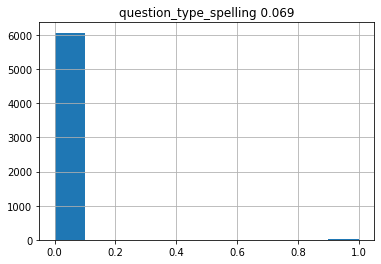

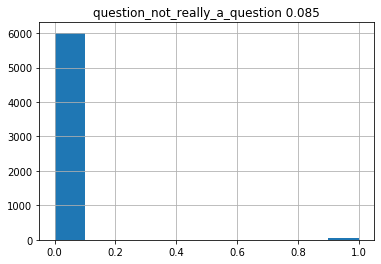

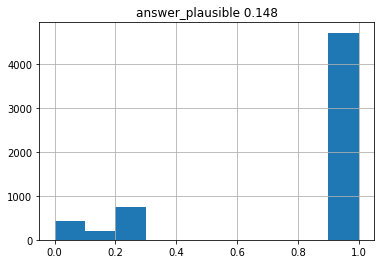

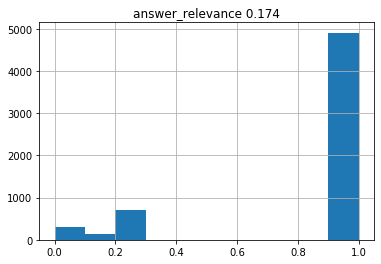

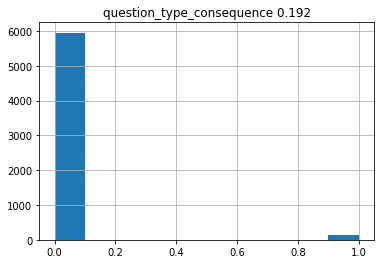

In [21]:
for col in worst_five_targets:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


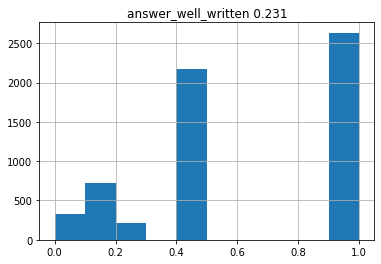

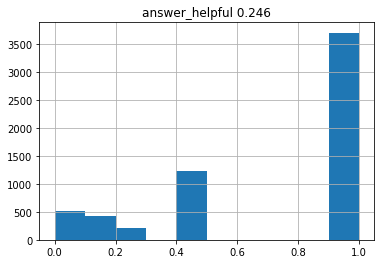

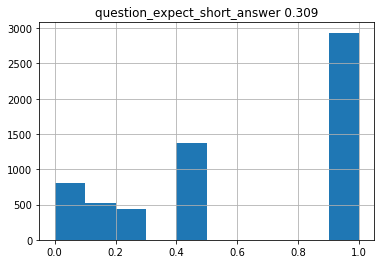

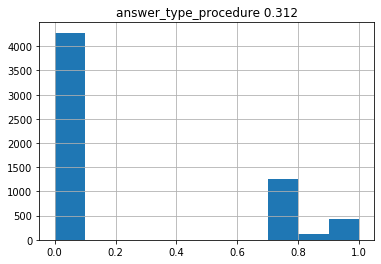

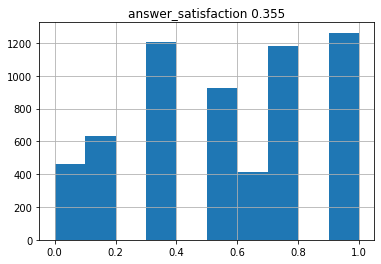

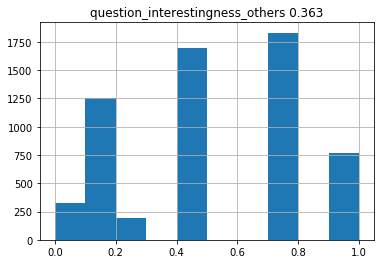

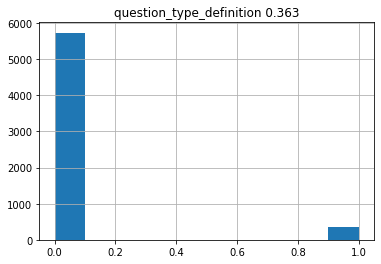

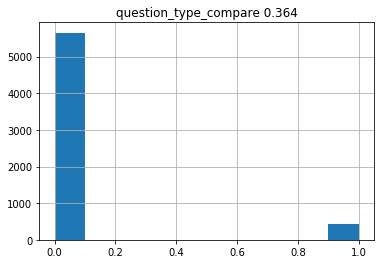

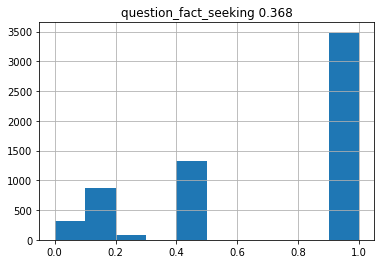

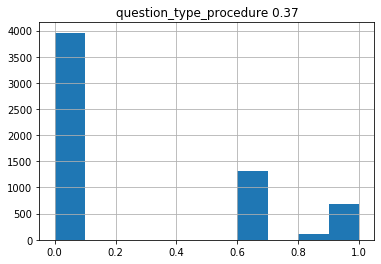

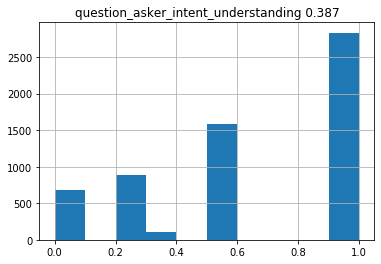

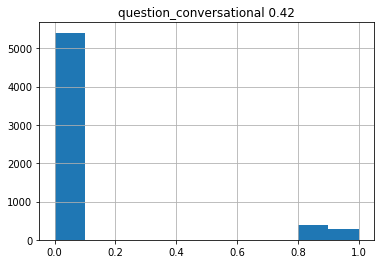

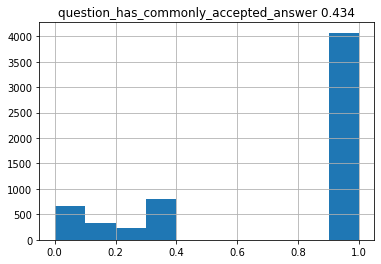

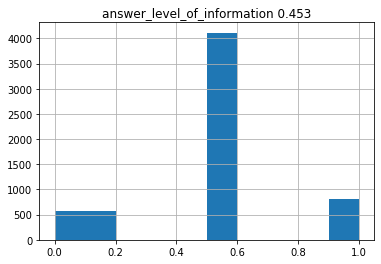

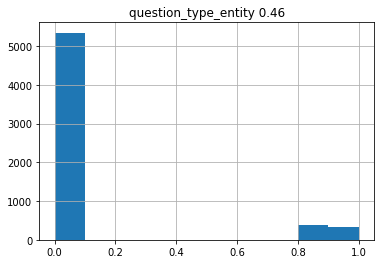

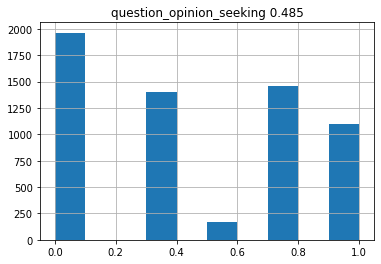

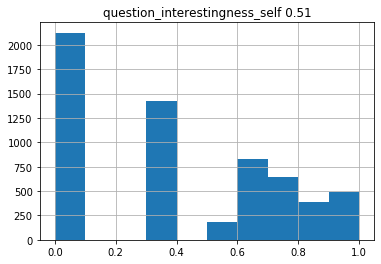

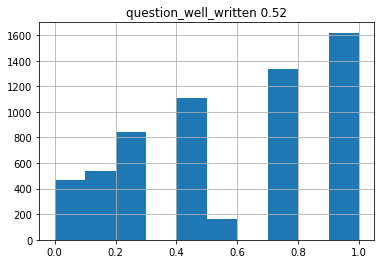

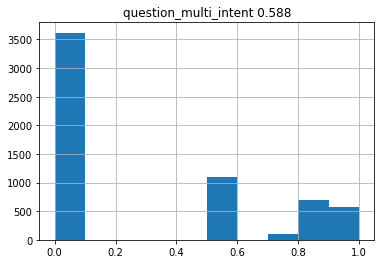

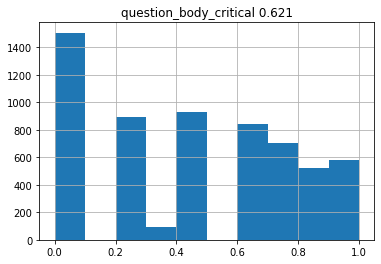

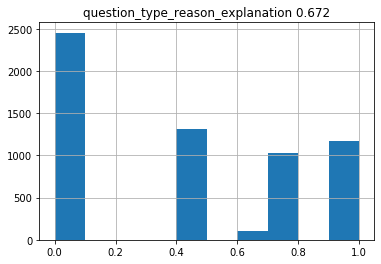

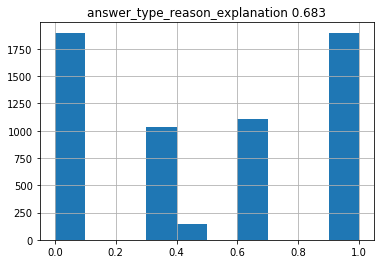

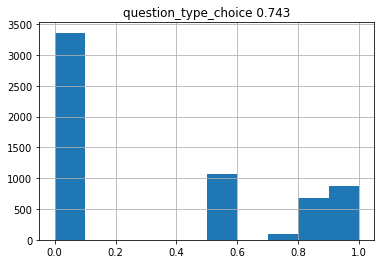

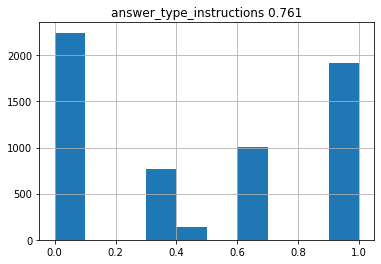

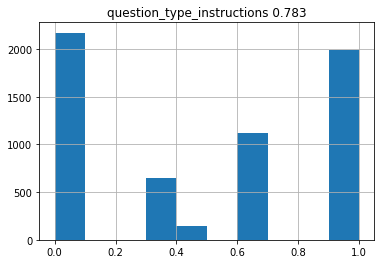

In [22]:
for col in [target for target in sorted_targets if target not in worst_five_targets]:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')